In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly as py
# import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from itertools import product
import scipy as sp
from scipy.special import expit

from compton import expansion_parameter, expansion_parameter_transfer_cm, order_transition, coefficients
from compton import mass_proton, mass_neutron

from os import path

from compton import create_observable_set
from compton import omega_lab_cusp

%matplotlib inline

In [15]:
fontsize = 8
black = 'k'

mpl.rcdefaults()  # Set to defaults

mpl.rc('text', usetex=True)
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['axes.edgecolor'] = black
# mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = black
mpl.rcParams['axes.linewidth']
mpl.rcParams['axes.titlesize'] = fontsize

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['xtick.color'] = black
mpl.rcParams['ytick.color'] = black
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

mpl.rcParams['hatch.linewidth'] = 0.5

mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

In [2]:
df = pd.read_csv('../data/compton_observables.csv', index_col=False)

obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df_ratio = pd.read_csv(obs_file, dtype={'observable': str})
compton_obs = create_observable_set(df=df_ratio, cov_exp=0.)

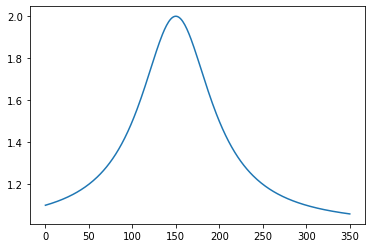

In [4]:
height = 5

xx = np.linspace(0, 350, 300)
xx_pi = 150
width = 50

# ref_scale = 1 / ((xx - xx_pi)**2/width**2 + 1/(height-1)) + 1
def ref_scale(omega, omega_pi, height, width=50):
    return 1 / ((omega - omega_pi)**2/width**2 + 1/(height-1)) + 1

plt.plot(xx, ref_scale(xx, omega_lab_cusp, 2, width))

In [22]:
obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]

heights = [
    150, 4, 4, 4, 4, 10, 8, 4, 3, 4, 4, 8, 4
]
heights_dict = {obs: height for obs, height in zip(obs_vals, heights)}
# obs_vals = [
#     'crosssection'
# ]
systems = ['neutron', 'proton']
order_map = {0: 0, 2: 1, 3: -1, 4: 2}
orders = np.array([0, 2, 3, 4])

coeffs_dict = {}
coeffs_unscaled_dict = {}

for obs, system in product(obs_vals, systems):
    print(obs, system)
    height = heights_dict[obs]
    # df_obs = df[(df['observable'] == obs) & (df['system'] == system)]
    # X = df_obs[['omegalab [MeV]', 'thetalab [deg]']].values
    # omega = np.unique(X[:, 0])
    # degrees = np.unique(X[:, 1])
    # cos0_lab = np.cos(np.deg2rad(X[:, 1]))
    #
    # Lambdab = 600
    # Q = expansion_parameter(X, Lambdab)
    # orders = np.array([0, 2, 3, 4])
    # y = df_obs[['y0', 'y2', 'y3', 'y4']].values
    # y_grid = y.reshape(len(omega), len(degrees), -1)
    # ref = 1.
    # if obs == 'crosssection' and system == 'proton':
    #     # ref = thompson_limit(X[:, 1].ravel())
    #     ref = dsg_proton_low_energy(cos0_lab.ravel())
    # coeffs = coefficients(y, ratio=Q, orders=orders, ref=ref)
    # coeffs_grid = coeffs.reshape(len(omega), len(degrees), -1)

    df_obs = df[(df['observable'] == obs) & (df['nucleon'] == system)]
    # df_obs = df[(df['is_numerator'] is True) & (df['order'] == 4)]

    # df_obs = df_rescaled[(df_rescaled['observable'] == obs) & (df_rescaled['nucleon'] == system)]
    X = df_obs[['omegalab [MeV]', 'thetalab [deg]']].values
    omega = np.unique(X[:, 0])
    degrees = np.unique(X[:, 1])

    mass = mass_proton if system == 'proton' else mass_neutron

    Lambdab = 650
    # Q = expansion_parameter2(X, Lambdab)
    Q = expansion_parameter_transfer_cm(X, Lambdab, mass)
    ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
    # ord_vals = orders
    y = df_obs[['y0', 'y2', 'y3', 'y4']].values

    # Replace with different LEC values
#     from compton import proton_pol_vec_mean, neutron_pol_vec_mean
#     p0 = proton_pol_vec_mean if system == 'proton' else neutron_pol_vec_mean
#     y[:, 2] = compton_obs[obs, system, 3, 'nonlinear'].prediction_ratio(p0)
#     y[:, 3] = compton_obs[obs, system, 4, 'nonlinear'].prediction_ratio(p0)

    y_grid = y.reshape(len(omega), len(degrees), -1)
    ref = 1.
    if obs == 'crosssection':
        ref = df_obs['y4'].values
        
    coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
    coeffs_grid = coeffs.reshape(len(omega), len(degrees), -1)
    coeffs_unscaled_dict[obs, system] = coeffs_grid
        
    ref *= ref_scale(X[:, 0], omega_lab_cusp, height)
    coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
    coeffs_grid = coeffs.reshape(len(omega), len(degrees), -1)
    coeffs_dict[obs, system] = coeffs_grid

crosssection neutron
crosssection proton
1Xp neutron
1Xp proton
1X neutron
1X proton
1Zp neutron
1Zp proton
1Z neutron
1Z proton
2Xp neutron
2Xp proton
2X neutron
2X proton
2Zp neutron
2Zp proton
2Z neutron
2Z proton
3 neutron
3 proton
3Yp neutron
3Yp proton
3Y neutron
3Y proton
Y neutron
Y proton


(74, 37, 4)


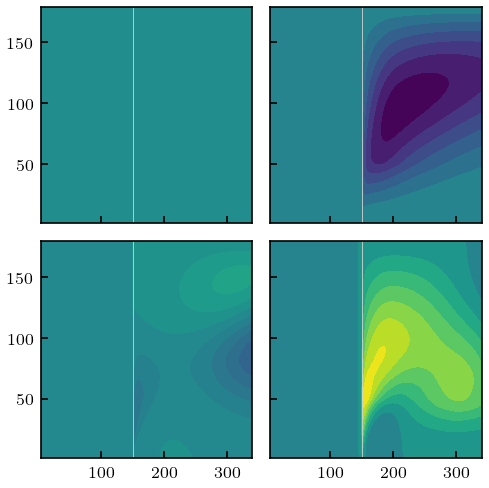

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex=True, sharey=True)

coeffs = coeffs_dict['1Xp', 'proton']
print(coeffs.shape)

for i, n in enumerate(orders):
    
    minz, maxz = coeffs.min(), coeffs.max()
    ax = axes.ravel()[i]
    ax.contourf(omega, degrees,coeffs[..., i].T, vmin=minz, vmax=maxz)
    ax.axvline(omega_lab_cusp, 0, 1, c='lightgrey', lw=0.4)
    
fig.tight_layout()

In [37]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian

In [91]:
x = np.linspace(0, 1, 40)
y = np.linspace(0, 1, 41)
y_fit = np.array([0, 1])

Z = cartesian([x, y])

npts = Z.shape[0]

X = Z[:, [0]]
Y = Z[:, [1]]
Y_fit = y_fit[:, None]


ell_x = 0.3
ell_y = 0.3
kern_y = RBF(ell_y) + WhiteKernel(1e-6)
kern_x = RBF(ell_x) + WhiteKernel(1e-6)

K_x = kern_x(X)
K_y = kern_y(Y)

print(Y.shape, Y_fit.shape)
K_y_constrained = K_y - kern_y(Y, Y_fit) @ np.linalg.solve(kern_y(Y_fit), kern_y(Y_fit, Y))

(1640, 1) (2, 1)


In [92]:
Y.shape

(1640, 1)

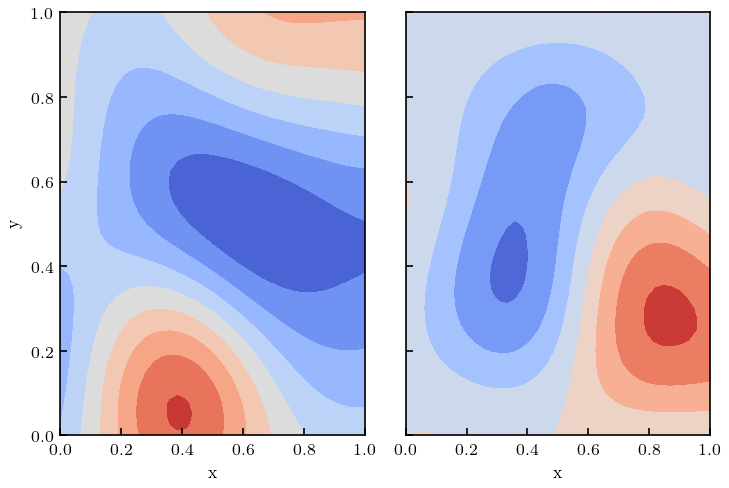

In [94]:
from scipy import stats

mvn_unconstrained = stats.multivariate_normal(mean=np.zeros(npts), cov=K_x * K_y)
mvn_constrained = stats.multivariate_normal(mean=np.zeros(npts), cov=K_x * K_y_constrained)

np.random.seed(1)

cmap = 'coolwarm'
levels = None

f_unconstrained = 20*mvn_unconstrained.rvs(1).reshape((x.size, y.size)).T
f_constrained = 20*mvn_constrained.rvs(1).reshape((x.size, y.size)).T

fig, axes = plt.subplots(1, 2, figsize=(5, 3.4), sharex=True, sharey=True)
axes[0].contourf(x, y, f_unconstrained, cmap=cmap, levels=levels)
axes[1].contourf(x, y, f_constrained, cmap=cmap, levels=levels)

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('x')
fig.tight_layout()

In [88]:
# plt.contourf()

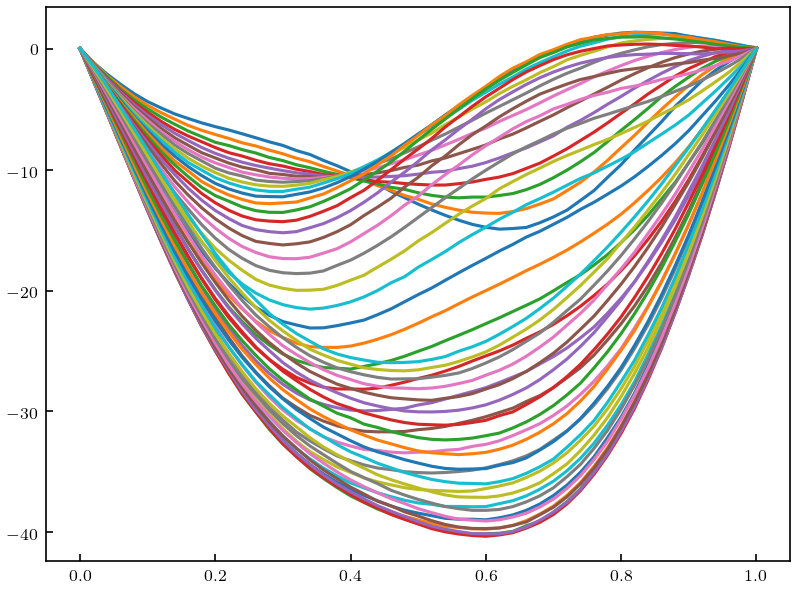

In [89]:
plt.plot(y, f_constrained);